In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL.DdsImagePlugin import module
from keras.src.layers import average
from tensorflow.python.tpu.tpu_system_metadata import master_job
from torch.nn.functional import layer_norm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
class FourierPositionalEncoding(nn.Module):
    def __init__(self, num_bands, max_resolution):
        super(FourierPositionalEncoding, self).__init__()
        self.num_bands = num_bands
        self.max_resolution = max_resolution
        frequencies = torch.linspace(1.0, max_resolution / 2, steps = num_bands)
        self.register_buffer('frequencies', frequencies)

    def forward(self, x):
        out = [x]
        for freq in self.frequencies:
            angles = torch.pi * freq * x
            out += [angles.sin(), angles.cos()]
        return torch.cat(out, dim = -1)

In [3]:
H, W = 224, 224
num_bands = 6
coords_y = torch.linspace(-1, 1, H)
coords_x = torch.linspace(-1, 1, W)
grid_y, grid_x = torch.meshgrid(coords_y, coords_x, indexing='ij')
pos = torch.stack([grid_x, grid_y], dim=-1)

x = torch.rand(10, 224 * 224, 3)
frontier_pos_encodin = FourierPositionalEncoding(num_bands, H)
pos_encoding = frontier_pos_encodin(pos)

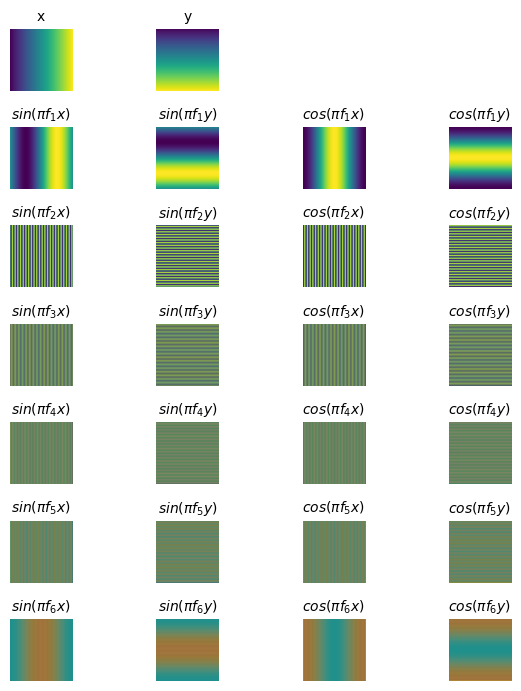

In [4]:
titles = ["x", "y"]
for f in range(1, 6+1):
    titles += [f"$sin(πf_{f}x)$", f"$sin(πf_{f}y)$", f"$cos(πf_{f}x)$", f"$cos(πf_{f}y)$"]

plt.figure(figsize=(6, 8))
for dim in range(26):
    plt.subplot(8, 4, dim + 1 + (2 if dim > 1 else 0))
    plt.imshow(pos_encoding[..., dim])
    plt.title(titles[dim], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class FrontierPositionalEncoding(nn.Module):
    def __init__(self, num_bands, max_resolution, input_dim):
        super(FrontierPositionalEncoding, self).__init__()
        self.num_bands = num_bands
        self.max_resolution = max_resolution
        self.input_dim = input_dim

        freq = torch.linspace(1.0, max_resolution / 2.0, steps = num_bands)
        self.register_buffer('freq', freq)

    def forward(self, positions):
        batch,input_token, dim = positions.shape
        assert dim == self.input_dim, f'Expected input dimension of {self.input_dim}, got {dim}'
        freq = self.freq.view(1,1,1,-1)
        pos_expanded = positions.unsqueeze(-1)
        angles = torch.pi * pos_expanded * freq
        sin_part = torch.sin(angles)
        cos_part = torch.cos(angles)
        enc = torch.cat([pos_expanded, sin_part, cos_part], dim = -1)
        enc = enc.view(batch, input_token, -1)
        return enc

In [7]:
FPE = FrontierPositionalEncoding(num_bands = 10, max_resolution = 256, input_dim = 2)
position = torch.rand((2,5,2))
pos_encoding = FPE(pos)

In [8]:
pos_encoding

tensor([[[-1.0000e+00,  8.7423e-08,  3.4202e-01,  ...,  7.6606e-01,
           9.3970e-01,  1.0000e+00],
         [-9.9103e-01, -2.8172e-02, -7.6623e-02,  ...,  7.6606e-01,
           9.3970e-01,  1.0000e+00],
         [-9.8206e-01, -5.6322e-02, -4.8159e-01,  ...,  7.6606e-01,
           9.3970e-01,  1.0000e+00],
         ...,
         [ 9.8206e-01,  5.6322e-02,  4.8159e-01,  ...,  7.6606e-01,
           9.3970e-01,  1.0000e+00],
         [ 9.9103e-01,  2.8172e-02,  7.6623e-02,  ...,  7.6606e-01,
           9.3970e-01,  1.0000e+00],
         [ 1.0000e+00, -8.7423e-08, -3.4202e-01,  ...,  7.6606e-01,
           9.3970e-01,  1.0000e+00]],

        [[-1.0000e+00,  8.7423e-08,  3.4202e-01,  ..., -9.3311e-01,
          -9.1457e-01, -8.9388e-01],
         [-9.9103e-01, -2.8172e-02, -7.6623e-02,  ..., -9.3311e-01,
          -9.1457e-01, -8.9388e-01],
         [-9.8206e-01, -5.6322e-02, -4.8159e-01,  ..., -9.3311e-01,
          -9.1457e-01, -8.9388e-01],
         ...,
         [ 9.8206e-01,  5

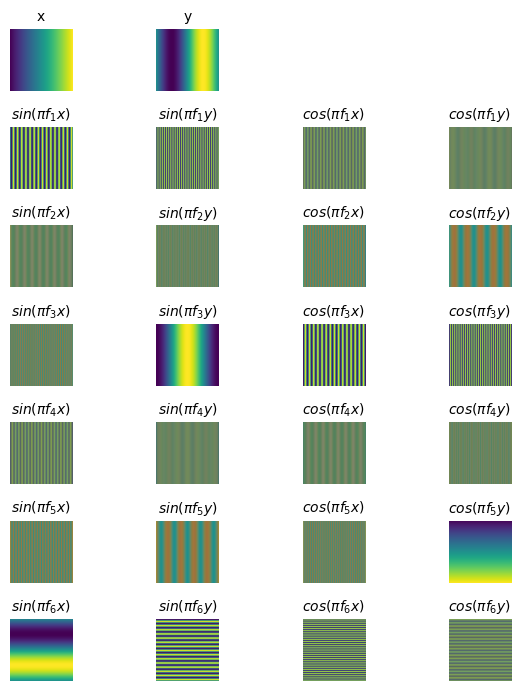

In [9]:
titles = ["x", "y"]
for f in range(1, 6+1):
    titles += [f"$sin(πf_{f}x)$", f"$sin(πf_{f}y)$", f"$cos(πf_{f}x)$", f"$cos(πf_{f}y)$"]

plt.figure(figsize=(6, 8))
for dim in range(26):
    plt.subplot(8, 4, dim + 1 + (2 if dim > 1 else 0))
    plt.imshow(pos_encoding[..., dim])
    plt.title(titles[dim], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [44]:
class PerceiverAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(PerceiverAttention, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, n_heads, batch_first=True)

        #FeedForward
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)

        #Dropout
        self.dropout = nn.Dropout(dropout)

        #Layernorm
        self.layer_norm = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        attention_output, _ = self.self_attention(x, x, x, need_weights=True, average_attn_weights = True)
        x = self.layer_norm(x + attention_output)
        ff = self.lin2(F.gelu(self.lin1(x)))
        x = self.dropout(x)
        x = self.layer_norm2(x + ff)
        return x


In [46]:
class PreceiverCrossAttention(nn.Module):
    def __init__(self, d_q, d_kv, d_model, n_heads, d_ff, dropout=0.1):
        super(PreceiverCrossAttention, self).__init__()

        #Q = XqWq, K= XkvWk, V = XkvWv
        self.q_proj = nn.Linear(d_q, d_model)
        self.k_proj = nn.Linear(d_kv, d_model)
        self.v_proj = nn.Linear(d_kv, d_model)

        #Cross attention Operator
        self.attention = nn.MultiheadAttention(d_model, n_heads, batch_first=True)

        #Layernorm

        self.layer_norm = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

        ##FeedForward
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)

        #   Drop Out
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key):
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(key)

        attention_output, _ = self.attention(q,k,v)
        x = self.layer_norm(query + attention_output)
        ff = self.lin2(F.gelu(self.lin1(x)))
        x = self.dropout(x)
        x = self.layer_norm2(x + ff)
        return x



In [47]:
class MiniPerceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, latent_size, num_layers, n_heads, d_ff, num_queries, output_dim, num_frequencies, max_postions):
        super(MiniPerceiver, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.latent_size = latent_size
        self.num_queries = num_queries

        self.latent = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_proj = nn.Linear(input_dim, latent_dim)

        self.pos_enc = FrontierPositionalEncoding(
            num_bands = num_frequencies,
            max_resolution= max_postions,
            input_dim =1
        )

        pe_dim = 1 * (2 * num_frequencies + 1)
        self.pe_proj = nn.Linear(pe_dim, input_dim)


        self.input_cross_attn = PreceiverCrossAttention(
            d_q=latent_dim,
            d_kv=latent_dim,
            d_model=latent_dim,
            n_heads=n_heads,
            d_ff=d_ff,
        )

        self.latent_block  = nn.ModuleList([
            PerceiverAttention(d_model=latent_dim, n_heads=n_heads, d_ff=d_ff) for _ in range(num_layers)
        ])

        self.query_embed = nn.Parameter(torch.randn(num_queries, latent_dim))
        self.output_cross_attn = PreceiverCrossAttention(
            d_q=latent_dim,
            d_kv=latent_dim,
            n_heads=n_heads,
            d_model=latent_dim,
            d_ff=d_ff
        )
        self.out_proj = nn.Linear(latent_dim, output_dim)

    def forward(self, x):
        b, n, d_in = x.shape
        postions = torch.linspace(-1.0, 1.0, steps = n, device=x.device)
        postions = postions.view(1, n, 1).expand(b, -1, -1)

        pe = self.pos_enc(postions)
        pe = self.pe_proj(pe)
        x = x + pe
        x = self.input_proj(x)
        latent = self.latent.unsqueeze(0).expand(b, -1, -1)
        latent = self.input_cross_attn(latent, x)
        for block in self.latent_block:
            latent = block(latent)

        queries = self.query_embed.unsqueeze(0).expand(b, -1, -1)
        y_Latent = self.output_cross_attn(queries, latent)
        y = self.out_proj(y_Latent)
        return y


In [48]:
class ToySequenceDataset(Dataset):
    def __init__(self, num_samples, seq_len, input_dim):
        super().__init__()

        self.num_samples = num_samples
        self.seq_len = seq_len
        self.input_dim = input_dim

        self.data = torch.randn(num_samples, seq_len, input_dim)
        means = self.data.mean(dim=1).mean(dim=1)
        self.labels = (means > 0.0).long()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


seq_len = 128
input_dim = 4
latent_dim = 64
latent_size = 32
num_layers = 4
n_heads = 4
d_ff = 128
num_queries = 1
output_dim = 2
num_freqs = 6
max_positions = seq_len

model = MiniPerceiver(
    input_dim=input_dim,
    latent_dim=latent_dim,
    latent_size=latent_size,
    num_layers=num_layers,
    n_heads=n_heads,
    d_ff=d_ff,
    num_queries=num_queries,
    output_dim=output_dim,
    num_frequencies = num_freqs,
    max_postions = max_positions,
).to(device)

train_dataset = ToySequenceDataset(4000, seq_len, input_dim)
val_dataset = ToySequenceDataset(1000, seq_len, input_dim)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# AdamW optimizer: θ ← θ − η∇θ + weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)

# Cross-entropy:  L = −Σ y log(ŷ)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()

    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        # Forward pass: ŷ = fθ(x)
        logits = model(x).squeeze(1)

        # L(ŷ, y)
        loss = criterion(logits, y)

        # ∂L/∂θ
        loss.backward()

        # θ ← θ − η∇θ
        optimizer.step()

        total_loss += loss.item() * x.size(0)

        preds = logits.argmax(dim=-1)
        total_correct += (preds == y).sum().item()
        total_examples += x.size(0)

    train_loss = total_loss / total_examples
    train_acc = total_correct / total_examples

    model.eval()
    val_correct = 0
    val_examples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x).squeeze(1)
            preds = logits.argmax(dim=-1)

            val_correct += (preds == y).sum().item()
            val_examples += x.size(0)

    val_acc = val_correct / val_examples

    print(f"Epoch {epoch+1} | train loss {train_loss:.4f} | train acc {train_acc:.3f} | val acc {val_acc:.3f}")


Epoch 1 | train loss 0.6832 | train acc 0.549 | val acc 0.806
Epoch 2 | train loss 0.2282 | train acc 0.902 | val acc 0.926
Epoch 3 | train loss 0.1289 | train acc 0.946 | val acc 0.926
Epoch 4 | train loss 0.1130 | train acc 0.950 | val acc 0.972
Epoch 5 | train loss 0.0865 | train acc 0.963 | val acc 0.979


##### TTS with Perceiver